# Implement Online portfolio algorithms directly into the Gyn environment

In [16]:
import numpy as np
import pandas as pd

from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback
from typing import Any, ClassVar, Dict, Iterable, List, Optional, Tuple, Type, TypeVar, Union

class OLMARModel:
    def __init__(
            self, 
            env: Union[GymEnv, str],
            policy: Any, # Policy doesnt matter here
            device: str, # device doesnt matter here
            policy_kwargs: Optional[Dict[str, Any]] = None, # policy_kwargs doesnt matter here
            target_weights: List[float] = None, # If none, default to uniform weights
            window=5, 
            eps=10,
            ) -> None:
        
        # Super simple algorithm, we only need the environment

        assert env is not None 
        self.env = env

        self.window = window
        self.eps = eps

        # Pull out the actions space dimensions for the portfolio
        self.action_space_shape = self.env.action_space.shape
        self.portfolio_length = self.action_space_shape[0]

        # Calculate the inital weights, (defualt to uniform)
        # Uniform base case
        # Note these are the first weight reprsents the cash account, which should always be 0
        self.current_weights = np.ones(self.portfolio_length-1) / (self.portfolio_length-1)  # target weights for each asset

        # For OLMAR start with uniform and then adjust based on moving averages
        self.price_history = pd.DataFrame()

    def train(self) -> None:
        # This model is derministic and doesnt learn anything, it only predicts
        raise NotImplementedError("Can't use 'train' on a benchmark model, use predict instead. These models are deterministic.")

    def learn(
        self
    ):
        # This model is derministic and doesnt learn anything, it only predicts
        raise NotImplementedError("Can't use 'learn' on a benchmark model, use predict instead. These models are deterministic.")

    def get_SMA(self, window_history):
        """Predict next price relative using SMA."""
        return window_history.mean() / window_history.iloc[-1, :]
        
    def update_weights(self, weights, new_price_prediction):
        """Update portfolio weights to satisfy constraint weights * x >= eps
        and minimize distance to previous weights."""
        price_prediction_mean = np.mean(new_price_prediction)
        excess_return = new_price_prediction - price_prediction_mean
        denominator = (excess_return * excess_return).sum()
        if denominator != 0:
            lam = max(0.0, (self.eps - np.dot(weights, new_price_prediction)) / denominator)
        else:
            lam = 0

        # update portfolio
        weights = weights + lam * (excess_return)

        # project it onto simplex
        return simplex_projection(weights)

    def predict(self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False, # This is always determininistic
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:

        # This comes from the policies class in stable baselines.
        # Use this to validate the environment.
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )

        # Reshape the array to remove single dimensions 
        reshaped_array = observation.reshape(len(self.env._features), self.portfolio_length - 1) 

        # This assumes the close prices are in the environment.
        # This will break if close prices are not first in the environment
        # TODO fix this
        prices = reshaped_array[0].tolist()

        new_row = pd.DataFrame([prices])

        # Add to the price history
        self.price_history = pd.concat([self.price_history, new_row], ignore_index=True)
        old_weights = self.current_weights

        # Normalize the prices
        normals = {}
        for col, close_prices in self.price_history.items():
            init_val = close_prices.loc[close_prices.first_valid_index()]
            normals[col] = close_prices / init_val
        price_relatives = pd.DataFrame(normals)

        # Window is too short, return the starting weights
        if len(price_relatives) < self.window + 1:
            self.price_prediction = price_relatives.iloc[-1]
        else:
            window_history = price_relatives.iloc[-self.window :]
            self.price_prediction = self.get_SMA(window_history)
            
        new_weights = self.update_weights(old_weights, self.price_prediction)

        self.current_weights = new_weights

        assert np.isclose(self.current_weights.sum(), 1), "The array does not sum up to one."

        # Use the last portfolio as the new action (keep it the same)
        action_weights = np.insert(new_weights, 0, 0)
        actions = action_weights.reshape(1, self.portfolio_length)

        return actions, None

def simplex_projection(weights):
    """Projection of weights onto simplex."""
    weight_length = len(weights)
    found = False

    sorted_weights = sorted(weights, reverse=True)
    running_sum = 0.0

    for weight_i in range(weight_length - 1):
        running_sum = running_sum + sorted_weights[weight_i]
        threshhold_max = (running_sum - 1) / (weight_i + 1)
        if threshhold_max >= sorted_weights[weight_i + 1]:
            found = True
            break

    if not found:
        threshhold_max = (running_sum + sorted_weights[weight_length - 1] - 1) / weight_length

    return np.maximum(weights - threshhold_max, 0.0)     

In [17]:
from stable_baselines3 import PPO

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CheckpointCallback

from stable_baselines3.common.policies import ActorCriticPolicy

from typing import Any, Dict, List, Optional, Tuple, Type, TypeVar, Union, Callable

from gym import spaces

import torch as th
from torch import nn
import numpy as np

from stable_baselines3.common.torch_layers import (
    BaseFeaturesExtractor,
    CombinedExtractor,
    FlattenExtractor,
    MlpExtractor,
    NatureCNN,
    create_mlp,
)

from stable_baselines3.common.type_aliases import Schedule


MODELS = {
    "ppo": PPO, 

    "olmar": OLMARModel,

}

# We tweak the ActorCriticPolicy to apply softmax normalization to the output actions
class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Schedule,
        net_arch: Optional[Union[List[int], Dict[str, List[int]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        ortho_init: bool = True,
        use_sde: bool = False,
        log_std_init: float = 0.0,
        full_std: bool = True,
        use_expln: bool = False,
        squash_output: bool = False,
        features_extractor_class: Type[BaseFeaturesExtractor] = FlattenExtractor,
        features_extractor_kwargs: Optional[Dict[str, Any]] = None,
        share_features_extractor: bool = True,
        normalize_images: bool = True,
        optimizer_class: Type[th.optim.Optimizer] = th.optim.Adam,
        optimizer_kwargs: Optional[Dict[str, Any]] = None,
        **kwargs,
    ):

        # Pass all initialization variables to the base class
        super().__init__(
            observation_space=observation_space,
            action_space=action_space,
            lr_schedule=lr_schedule,
            net_arch=net_arch,
            activation_fn=activation_fn,
            ortho_init=ortho_init,
            use_sde=use_sde,
            log_std_init=log_std_init,
            full_std=full_std,
            use_expln=use_expln,
            squash_output=squash_output,
            features_extractor_class=features_extractor_class,
            features_extractor_kwargs=features_extractor_kwargs,
            share_features_extractor=share_features_extractor,
            normalize_images=normalize_images,
            optimizer_class=optimizer_class,
            optimizer_kwargs=optimizer_kwargs,
            **kwargs
        )

        # Set up the softmax function
        self.softmax = nn.Sequential(nn.Softmax(dim=-1))

    def _build_mlp_extractor(self) -> None:
        """
        Create the policy and value networks.
        Part of the layers can be shared.
        """
        # Note: If net_arch is None and some features extractor is used,
        #       net_arch here is an empty list and mlp_extractor does not
        #       really contain any layers (acts like an identity module).
        self.mlp_extractor = MlpExtractor(
            self.features_dim,
            net_arch=self.net_arch,
            activation_fn=self.activation_fn,
            device=self.device,
        )

    def forward(self, obs: th.Tensor, deterministic: bool = False) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        # Preprocess the observation if needed
        features = self.extract_features(obs)
        if self.share_features_extractor:
            latent_pi, latent_vf = self.mlp_extractor(features)
        else:
            pi_features, vf_features = features
            latent_pi = self.mlp_extractor.forward_actor(pi_features)
            latent_vf = self.mlp_extractor.forward_critic(vf_features)
        # Evaluate the values for the given observations
        values = self.value_net(latent_vf)
        distribution = self._get_action_dist_from_latent(latent_pi)
        actions = distribution.get_actions(deterministic=deterministic)
        log_prob = distribution.log_prob(actions)
        actions = actions.reshape((-1, *self.action_space.shape))  # type: ignore[misc]

        # APPLY SOFTMAX to the actions
        actions = self.softmax(actions)

        return actions, values, log_prob
    
    def predict(
        self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False,
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:
        """
        Get the policy action from an observation (and optional hidden state).
        Includes sugar-coating to handle different observations (e.g. normalizing images).

        :param observation: the input observation
        :param state: The last hidden states (can be None, used in recurrent policies)
        :param episode_start: The last masks (can be None, used in recurrent policies)
            this correspond to beginning of episodes,
            where the hidden states of the RNN must be reset.
        :param deterministic: Whether or not to return deterministic actions.
        :return: the model's action and the next hidden state
            (used in recurrent policies)
        """
        # Switch to eval mode (this affects batch norm / dropout)
        self.set_training_mode(False)

        # Check for common mistake that the user does not mix Gym/VecEnv API
        # Tuple obs are not supported by SB3, so we can safely do that check
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )

        obs_tensor, vectorized_env = self.obs_to_tensor(observation)

        with th.no_grad():
            actions = self._predict(obs_tensor, deterministic=deterministic)

            # APPLY SOFTMAX to the actions
            actions = self.softmax(actions)

        # Convert to numpy, and reshape to the original action shape
        actions = actions.cpu().numpy().reshape((-1, *self.action_space.shape))  # type: ignore[misc, assignment]

        if isinstance(self.action_space, spaces.Box):
            if self.squash_output:
                # Rescale to proper domain when using squashing
                actions = self.unscale_action(actions)  # type: ignore[assignment, arg-type]
            else:
                # Actions could be on arbitrary scale, so clip the actions to avoid
                # out of bound error (e.g. if sampling from a Gaussian distribution)
                actions = np.clip(actions, self.action_space.low, self.action_space.high)  # type: ignore[assignment, arg-type]

        # Remove batch dimension if needed
        if not vectorized_env:
            assert isinstance(actions, np.ndarray)
            actions = actions.squeeze(axis=0)

        return actions, state  # type: ignore[return-value]
    
    
# We default to this agent using our custom actor critic policy
class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # Default to use the the custom policy which applies softmax normalization
        return model(env=self.env, policy=CustomActorCriticPolicy, **model_kwargs)

    @staticmethod
    def train_model(model, env, tb_log_name=None, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        checkpoint_callback = CheckpointCallback(
            save_freq=1000000,
            save_path="./results/",
            name_prefix="model_checkpoint",
            save_replay_buffer=True,
            save_vecnormalize=True,
        )

        model.learn(
            total_timesteps = max_steps * episodes,
            callback=checkpoint_callback,
            tb_log_name=tb_log_name,
            progress_bar=True
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True, verbose=False):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
            action, _states = model.predict(test_obs, deterministic=deterministic)

            if(verbose):
                print("Step: ", str(i))
                print("Observations: ")
                print(test_obs)
                print("Actions: ")
                print(action)

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [18]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

TEST_START_DATE = '2009-01-01'
TEST_END_DATE = '2024-10-01'


# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader


# # TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)



# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]



raw_df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()


from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)


from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

environment = PortfolioOptimizationEnv(
        portfolio_norm_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

OLMAR_results = {
    "date": {},
    "training": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

OLMAR_model_kwargs = {
    "eps": 60,
    "window": 100
}

# Training
agent_olmar = DRLStableAgent(env = environment)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=OLMAR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment)
OLMAR_results["training"] = environment._terminal_asset_memory["final"]
OLMAR_results["date"] = environment._terminal_date_memory



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (23772, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.39660606 0.62818164 0.68543954 ... 0.01947727 0.01808933 0.02899626]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.   0.   0.25 ... 0.75 1.   0.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: 

Initial portfolio value:1000000
Final portfolio value: 4122453.25
Final accumulative portfolio value: 4.12245325
Maximum DrawDown: -0.7357713709510374
Sharpe ratio: 0.43479493774955275
Total commission cost: 2709830.7877339753
hit end!


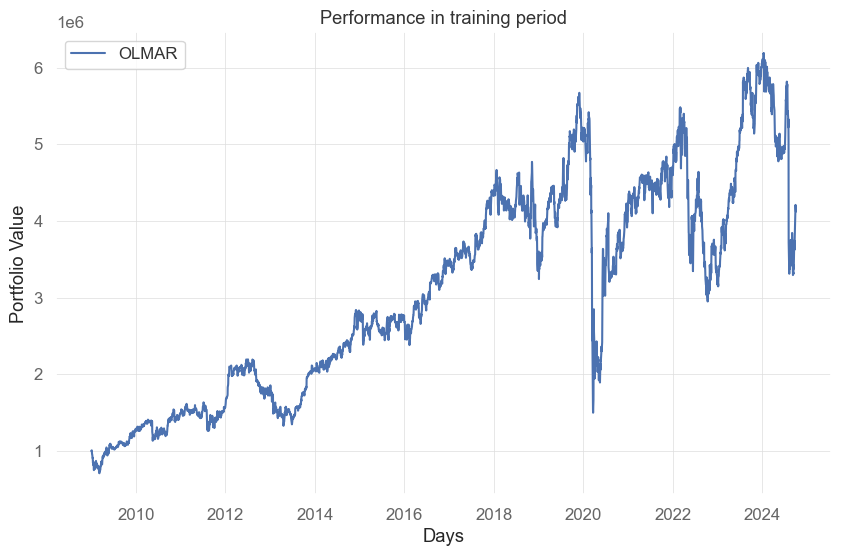

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(OLMAR_results["date"], OLMAR_results["training"], label="OLMAR")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

tic               AAPL          BA       INTC        MSFT           V  \
date                                                                    
2009-01-02    2.733995   33.941105   9.516952   14.954701   11.916506   
2009-01-05    2.849382   34.631157   9.335376   15.094462   12.001246   
2009-01-06    2.802385   34.736176   9.623386   15.271014   12.846370   
2009-01-07    2.741829   33.573551   9.041102   14.351514   12.567631   
2009-01-08    2.792743   33.596069   9.109974   14.800225   12.433837   
...                ...         ...        ...         ...         ...   
2024-09-24  227.120117  155.809998  22.809999  428.312683  272.262390   
2024-09-25  226.121216  152.220001  23.540001  431.246796  269.118347   
2024-09-26  227.269958  154.580002  23.920000  430.448395  271.174438   
2024-09-27  227.539658  156.320007  23.910000  427.164948  274.647858   
2024-09-30  232.743942  152.039993  23.459999  429.440399  274.428284   

tic               WMT  
date                   
20

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:243: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill")


Weights!!!!
AAPL    0.0
BA      0.0
INTC    0.0
MSFT    0.0
V       1.0
WMT     0.0
dtype: float64
Price2!!!!
AAPL    1.493995
BA      1.094394
INTC    1.081872
MSFT    1.180215
V       1.152114
WMT     0.858644
Name: 2009-06-17 00:00:00, dtype: float64
Weights!!!!
AAPL    0.0
BA      0.0
INTC    0.0
MSFT    0.0
V       1.0
WMT     0.0
dtype: float64
Price2!!!!
AAPL    1.497300
BA      1.103636
INTC    1.063774
MSFT    1.171244
V       1.153241
WMT     0.860766
Name: 2009-06-18 00:00:00, dtype: float64
Weights!!!!
AAPL    0.0
BA      0.0
INTC    0.0
MSFT    0.0
V       1.0
WMT     0.0
dtype: float64
Price2!!!!
AAPL    1.536970
BA      1.091915
INTC    1.073158
MSFT    1.199653
V       1.152490
WMT     0.851748
Name: 2009-06-19 00:00:00, dtype: float64
Weights!!!!
AAPL    0.0
BA      0.0
INTC    0.0
MSFT    0.0
V       1.0
WMT     0.0
dtype: float64
Price2!!!!
AAPL    1.513720
BA      1.057201
INTC    1.051038
MSFT    1.160279
V       1.150049
WMT     0.859175
Name: 2009-06-22 00:00:00,

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

about the convert!!!!!!!!!!!
                    0
date                 
2009-01-02   1.000000
2009-01-05   1.008062
2009-01-06   1.023294
2009-01-07   0.988149
2009-01-08   0.983633
...               ...
2024-09-24  17.113936
2024-09-25  17.139368
2024-09-26  17.208879
2024-09-27  17.253203
2024-09-30  17.234102

[3962 rows x 1 columns]
converted!!!!!!!!!!!
                   0
date                
2009-01-02  1.000000
2009-01-05  1.008062
2009-01-06  1.015110
2009-01-07  0.965656
2009-01-08  0.995429
...              ...
2024-09-24  0.991871
2024-09-25  1.001486
2024-09-26  1.004056
2024-09-27  1.002576
2024-09-30  0.998893

[3962 rows x 1 columns]
about the call weights!!!!!!!!!!!
                   0
date                
2009-01-02  1.000000
2009-01-05  1.008062
2009-01-06  1.015110
2009-01-07  0.965656
2009-01-08  0.995429
...              ...
2024-09-24  0.991871
2024-09-25  1.001486
2024-09-26  1.004056
2024-09-27  1.002576
2024-09-30  0.998893

[3962 rows x 1 columns]
about the

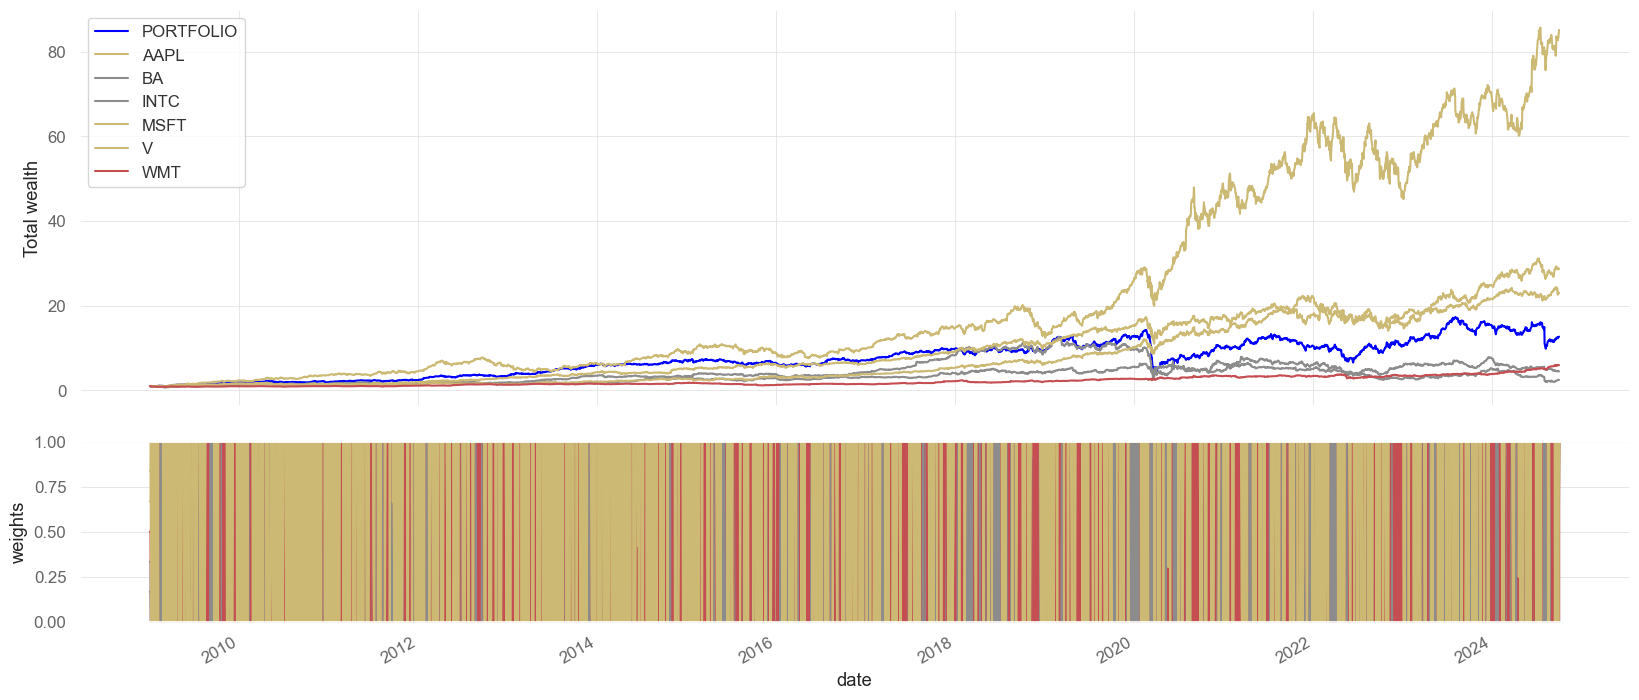

In [20]:
from online_algos import OLMAR

pivot_df = raw_df.pivot(index='date', columns='tic', values='close')

print(pivot_df)

pivot_df.index = pd.to_datetime(pivot_df.index)



algo = OLMAR(window=5, eps=10, ma_type="SMA")

result_olmar = algo.run(pivot_df)
print(result_olmar.summary())
result_olmar.plot()

print(result_olmar.B)

dimensions = result_olmar.B.shape 
print("Dimensions of the DataFrame:", dimensions)

In [21]:
# X = raw_df / raw_df.shift(1).fillna(method="ffill")

# X = X.fillna(1.0)


# pivoted_df = raw_df.pivot(index='date', columns='tic', values='close')
# print(pivoted_df)

print(pivot_df)

X = pivot_df / pivot_df.shift(1).fillna(method="ffill")

X = X.fillna(1.0)
print(X)

tic               AAPL          BA       INTC        MSFT           V  \
date                                                                    
2009-01-02    2.733995   33.941105   9.516952   14.954701   11.916506   
2009-01-05    2.849382   34.631157   9.335376   15.094462   12.001246   
2009-01-06    2.802385   34.736176   9.623386   15.271014   12.846370   
2009-01-07    2.741829   33.573551   9.041102   14.351514   12.567631   
2009-01-08    2.792743   33.596069   9.109974   14.800225   12.433837   
...                ...         ...        ...         ...         ...   
2024-09-24  227.120117  155.809998  22.809999  428.312683  272.262390   
2024-09-25  226.121216  152.220001  23.540001  431.246796  269.118347   
2024-09-26  227.269958  154.580002  23.920000  430.448395  271.174438   
2024-09-27  227.539658  156.320007  23.910000  427.164948  274.647858   
2024-09-30  232.743942  152.039993  23.459999  429.440399  274.428284   

tic               WMT  
date                   
20

C:\Users\bencj\AppData\Local\Temp\ipykernel_20116\2061739489.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = pivot_df / pivot_df.shift(1).fillna(method="ffill")
